# Decision Tree

In [19]:
import numpy as np
from collections import Counter
import pydot  #pour l'affichage graphique d'arbres
import cPickle
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
###############################
# Fonctions auxiliaires
###############################

def p_log_p(freq):
    """ fonction pour calculer \sum p_i log(p_i) """
    return np.nan_to_num(np.sum(freq*np.log2(freq)))
    """dafuck is not a number here ??? """ 
def entropy(y):
    """ calcul de l'entropie d'un ensemble"""
    ylen = float(y.size)
    if ylen <= 1:
        return 0    
    #freq est un tableau qui contient les probabilités de chaque dimension du vecteur
    freq = np.array(Counter(y).values())/ylen
    return -p_log_p(freq)

"""pour un noeud on calcule l'entropie avec les fils de ce 
noeud, y_list sont les fils """  
def entropy_cond(y_list):
    h, total = 0.,0.
    for y in y_list:
        h += len(y)*entropy(y)
        total += len(y)
    return h/total

In [3]:
###############################
# Classes
###############################
class Classifier(object):
    """ Classe generique d'un classifieur
        Dispose de 3 méthodes :
            fit pour apprendre
            predict pour predire
            score pour evaluer la precision
    """
    def fit(self,data,y):
        raise NotImplementedError("fit non  implemente")
    def predict(self,data):
        raise NotImplementedError("predict non implemente")
    def score(self,data,y):
        return (self.predict(data)==y).mean()

In [4]:
class Split(object):
    """ Permet de coder un split pour une variable continue
    """
    def __init__(self,idvar=None,threshold=None,gain=None):
        """
        :param idvar: numero de la variable de split
        :param threshold: seuil
        :param gain: gain d'information du split
        :return:
        """
        self.idvar=idvar
        self.threshold=threshold
        self.gain=gain

    def predict(self,data):
        """ Prediction pour une matrice d'exemples, -1 si <= threshold, +1 sinon
        :param x: matrice d'exemples
        :return: vecteur des labels
        """
        if len(data.shape)==1:
            data=data.reshape((1,data.shape[0]))
        return [-1 if data[i,self.idvar]<=self.threshold else 1 for i in range(data.shape[0])]

    @staticmethod
    def best_gain(x,y):
        """  calcul le meilleur seuil pour la colonne x (1-dimension) et les labels y
        :param x: vecteur 1d des donnees
        ;param y: vecteur des labels
        :return:
        """
        ylen = float(y.size)
        idx_sorted = np.argsort(x)
        h=entropy(y)
        xlast=x[idx_sorted[0]]
        split_val=x[idx_sorted[0]]
        hmin = h
        for i in range(y.size):
            if x[idx_sorted[i]]!=xlast:
                htmp = entropy_cond([y[idx_sorted[:i]], y[idx_sorted[i:]]])
                if htmp<hmin:
                    hmin=htmp
                    split_val=(xlast+x[idx_sorted[i]])/2.
            xlast=x[idx_sorted[i]]
        return (h-hmin/ylen),split_val

    @staticmethod
    def find_best_split(data,y):
        if len(data.shape)==1:
            data = data.reshape((1,data.shape[0]))
        hlist = [[Split.best_gain(data[:,i],y),i] for i in range(data.shape[1])]
        (h,threshold),idx= max(hlist)
        return Split(idx,threshold,h)

    def __str__(self):
        return "var %s, thresh %f (gain %f)" %(self.idvar,self.threshold, self.gain)

In [5]:
class Node(Classifier):
    """ Noeud d'un arbre
    """
    def __init__(self,split=None,parent=None,left=None,right=None,leaf=True,depth=-1,label=None,**kwargs):
        """
        :param split:  split du noeud
        :param parent: noeud parent, None si root
        :param left: fils gauche
        :param right: fils droit
        :param leaf: boolean vrai si feuille
        :param depth: profondeur
        :param label: label preponderant
        :return:
        """
        self.split, self.parent, self.left, self.right, self.leaf, self.label, self.depth = \
                                            split, parent, left, right, leaf, label, depth
        self.info = dict(kwargs)

    def predict(self,data):
        if len(data.shape)==1:
            data=data.reshape((1,data.shape[0]))
        if self.leaf:
            return [self.label]*data.shape[0]
        return [self.left.predict(data[i,:])[0] if res<0 else self.right.predict(data[i,:])[0]
                for i, res in enumerate(self.split.predict(data))]

    def fit(self, data, y):
        counts=Counter(y)
        self.split=Split.find_best_split(data, y)
        self.label = counts.most_common()[0][0]

    def __str__(self):
        if self.leaf:
            return "Leaf : %s" % (self.label,)
        return "Node : %s (%s)" % (self.split,self.info)

In [22]:
class DecisionTree(Classifier):
    """ Arbre de decision
    """

    def __init__(self,max_depth=None,min_samples_split=2):
        """
        :param max_depth: profondeur max
        :param min_samples_split:  nombre d'exemples minimal pour pouvoir spliter le noeud
        :return:
        """
        self.max_depth, self.min_samples_split = max_depth, min_samples_split
        self.root = None

    def fit(self,data,y):
        """ apprentissage de l'arbre de maniere iterative
        on apprend un noeud, puis on cree les deux enfants de ce noeud, que l'on ajoute a la pile des noeuds
        a traiter par la suite (nodes_to_treat), ainsi que les index des exemples associes (dic_idx)
        """
        self.root = Node(depth=0)
        nodes_to_treat = [self.root]
        dic_idx = dict({self.root : range(len(y))})
        while len(nodes_to_treat)>0:
            # recuperation du noeud courant
            curnode = nodes_to_treat.pop()
            #recuperation de la liste des indices des exemples associes, x[idx_train,:] contient l'ensemble des
            #exemples a traiter
            idx_train = dic_idx.pop(curnode)
            # infos complementaires sur le nombre d'exemples en apprentissage par label
            for lab,clab in Counter(y[idx_train]).items():
                curnode.info[lab]=clab
            curnode.fit(data[idx_train,:],y[idx_train])

            # recupere les predictions pour partager entre fils droit et gauche les exemples
            pred = curnode.split.predict(data[idx_train,:])
            l_idx = [ idx_train[i] for i in range(len(idx_train)) if pred[i]<0 ]
            r_idx = list(set(idx_train).difference(l_idx))

            #Condition d'arrets
            if entropy(y[idx_train])==0 or curnode.depth >= self.max_depth or \
                    len(l_idx) < self.min_samples_split or len(r_idx) < self.min_samples_split:
                curnode.leaf=True
                continue
            #Creation des deux enfants
            curnode.left = Node(parent=curnode,depth=curnode.depth+1)
            curnode.right = Node(parent=curnode,depth=curnode.depth+1)
            curnode.leaf = False
            #On enregistre les indices correspondant aux deux noeuds
            dic_idx[curnode.left]=l_idx
            dic_idx[curnode.right]=r_idx
            #On ajoute les deux enfants a la liste des noeuds a traiter
            nodes_to_treat = [curnode.left,curnode.right]+nodes_to_treat

    def predict(self,data):
        return self.root.predict(data)

    def __str__(self):
        s=""
        nodes=[self.root]
        while len(nodes)>0:
            curnode=nodes.pop()
            if not curnode.leaf:
                s+= "\t"*curnode.depth + "var %d :  <=|> %f \n"  %(curnode.split.idvar,curnode.split.threshold)
                nodes+=[curnode.left,curnode.right]
            else:
                s+= "\t"*curnode.depth + "class : %s\n" %(curnode.label,)
        return s

    def to_dot(self,dic_var=None):
        s="digraph Tree {"
        cpt=0
        nodes = [(self.root,cpt)]
        while len(nodes)>0:
            curnode,idx = nodes.pop()
            labinfo = ",".join(["%s: %s" % (lab,slab) for lab,slab in curnode.info.items()])
            if not curnode.leaf:
                s+="%d [label=\"%s <= %f\n IG=%f\n " %(idx,curnode.split.idvar \
                    if not dic_var else dic_var[curnode.split.idvar],curnode.split.threshold,curnode.split.gain)
                s+= " %s \n \",shape=\"box\" ];\n"  % (labinfo,)
                lidx = cpt +1
                ridx = cpt +2
                s+= "%d -> %d; %d -> %d;\n" % (idx,lidx,idx,ridx)
                cpt+=2
                nodes += [(curnode.left,lidx),(curnode.right,ridx)]
            else:
                s+= "%d [label=\"label=%s\n %s \"];\n" %(idx,curnode.label,labinfo)
        return s+"}"

    def to_pdf(self,filename,dic_var=None):
        pydot.graph_from_dot_data(self.to_dot(dic_var)).write_pdf(filename)


In [7]:
""" 
    data : tableau (films ,features), id2titles : dictionnaire  id ->
    titre film , fields : id  feature  -> nom
"""

"""id2titles= identifiants numeriques, """
[data , id2titles , fields]=cPickle.load(file("imdb_extrait.pkl"))
# la  derniere  colonne  est le vote
# colonne 33 = note 
datax=data[:,:32]
datay=np.array([1 if x[33]>6.5 else -1 for x in data])

In [8]:
"""datax = attributs sauf la note(label)"""
def entropie_attributs(datax):
    entro_att = []
    for j in range(32):
        entro_att.append(entropy(datax[:,j]))
    
    return entro_att

In [9]:
entro_att = entropie_attributs(datax)
print " l'entropie  pour chaque attribut est: "
print entro_att

 l'entropie  pour chaque attribut est: 
[0.56497683727455095, 0.72566201171310984, 0.75409468439050931, 0.26340380422197152, 0.1926285852674641, 0.94878054432465964, 0.26532686924303639, 0.53470135396321838, 0.040466328209344704, -0.0, -0.0, -0.0, 0.91047585246190077, 0.13310901662996316, 0.49425468209811785, 0.0078617369862958395, -0.0, 0.99991768338879861, 0.81032652362072333, 0.058438060605145864, 0.17702726334400468, 0.22865199105519707, 0.45026771320199777, 0.6915486835207777, 0.51449144629444865, -0.0, 0.19699814392010093, 0.30611790946760919, 6.2595536466159079, 0.2013306211270578, 5.445273694115901, 7.3099543096102986]


In [10]:
def entropie_conditionelle(datax,datay):
    filmClasse1 = []
    filmClasse2 = []
    h1,h2,total = 0.,0.,0.
    for i in range(len(datax)):
        if datay[i] == 1:
            filmClasse1.append(datax[i])
            h1 += 1
        else:
            filmClasse2.append(datax[i])
            h2 += 1
        total += 1
    fc1 = np.vstack(filmClasse1)
    fc2 = np.vstack(filmClasse2)
    entro_att1 = entropie_attributs(fc1)
    entro_att2 = entropie_attributs(fc2)
    entropie_con = []
    for i in range(32):
        entropie_con.append((h1*entro_att1[i] + h2*entro_att2[i])/total)
    return entropie_con

In [11]:
entropie_con = entropie_conditionelle(datax,datay)
print "\nl'entropie conditionnelle du vote binarise par rapport a l'attribut est: "
print entropie_con


l'entropie conditionnelle du vote binarise par rapport a l'attribut est: 
[0.55901436130809123, 0.72499279852927057, 0.7540918637247791, 0.26116743989647695, 0.19261186957530763, 0.93277938360084556, 0.25622695080186869, 0.51200772736662303, 0.036889528536906455, -0.0, -0.0, -0.0, 0.89902399391109633, 0.13107563937186639, 0.49412819987139917, 0.0073265570848683294, -0.0, 0.93925564833853581, 0.79388848151310953, 0.057182279638527976, 0.17456725571692763, 0.2150140648982273, 0.44838615981212071, 0.69127676003908511, 0.51220890501373184, -0.0, 0.1969965315043794, 0.28503315478992108, 6.1595622905099594, 0.18057232181748142, 5.3768790461211999, 7.1350564070605254]


In [12]:
def difference_arr_con(entro_att, entropie_con):
    diff = []
    for i in range(32):
        diff.append(entro_att[i]-entropie_con[i])
    return diff

In [13]:
difference = difference_arr_con(entro_att, entropie_con)
print "\ndifference entre ces 2 valeurs pour chaque attribut est: "
print difference


difference entre ces 2 valeurs pour chaque attribut est: 
[0.0059624759664597127, 0.00066921318383927897, 2.8206657302076721e-06, 0.0022363643254945664, 1.6715692156471507e-05, 0.016001160723814079, 0.0090999184411676981, 0.022693626596595351, 0.0035767996724382495, 0.0, 0.0, 0.0, 0.011451858550804439, 0.0020333772580967691, 0.0001264822267186827, 0.0005351799014275101, 0.0, 0.060662035050262797, 0.016438042107613793, 0.0012557809666178879, 0.0024600076270770432, 0.013637926156969765, 0.0018815533898770553, 0.00027192348169258196, 0.00228254128071681, 0.0, 1.612415721524707e-06, 0.021084754677688111, 0.099991356105948448, 0.020758299309576372, 0.068394647994701074, 0.17489790254977322]


In [23]:
dt = DecisionTree()
dt.max_depth = 5
#on fixe la  taille  de l'arbre a 5
dt.fit(datax ,datay)
dt.predict(datax[:5,:])
print "\nle score est: " + str(dt.score(datax ,datay))
dt.to_pdf("./doc/test_tree_6.pdf",fields)# dessine l'arbre  dans un  fichier pdf 


le score est: 0.736429038587


In [17]:
def plot_scores(arange,repeat,xTrain,yTrain):
    scores = []
    for depth in arange:
        #print "depth = " + str(depth)
        s = []
        for i in range(repeat):
            #print i
            dt = DecisionTree(max_depth=depth)
            dt.fit(xTrain,yTrain)
            dt.predict(datax[:5,:])
            s.append(dt.score(xTrain,yTrain))
        scores.append(np.mean(s))

    fig = plt.plot(range(2,10),scores,'b-')
    plt.xlabel("Depth of Decision Tree")
    plt.ylabel("Score")
    plt.show()

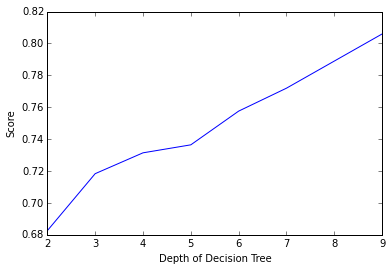

In [20]:
plot_scores(range(2,10),5,datax,datay)